/Users/iaamir/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


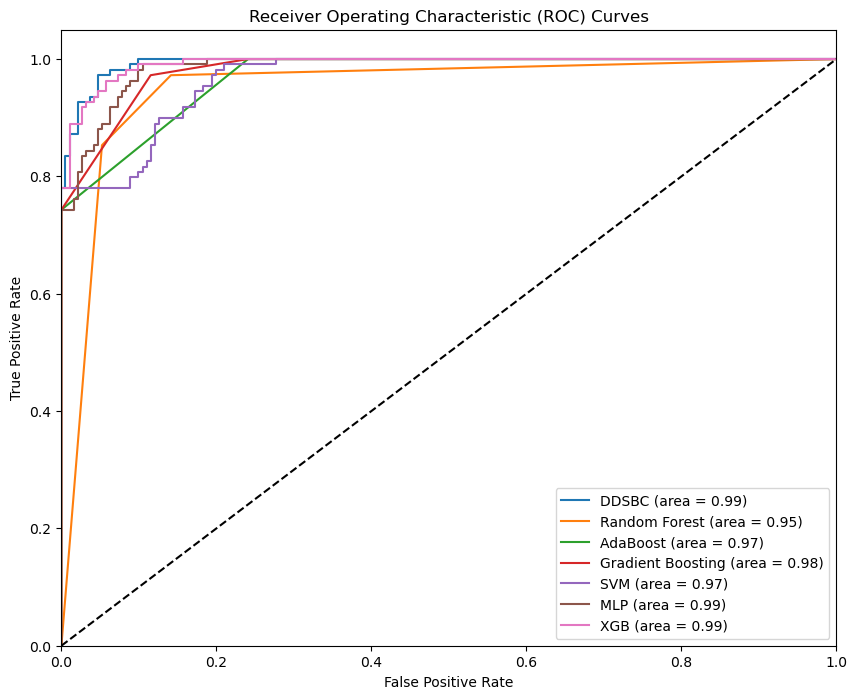

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your preprocessing code (loading data, feature encoding, splitting, etc.) goes here
# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')


# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
# Inner join ensures only matching rows are kept
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define the enhanced SMILES encoding function correctly
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
                Descriptors.NumRotatableBonds(mol), AllChem.CalcTPSA(mol), len(mol.GetRingInfo().AtomRings())]
    else:
        return [0] * 7

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features and PCA as before
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1),
                                  columns=['MolWt1', 'MolLogP1', 'NumHAcceptors1', 'NumHDonors1', 'NumRotatableBonds1', 'TPSA1', 'RingCount1',
                                           'MolWt2', 'MolLogP2', 'NumHAcceptors2', 'NumHDonors2', 'NumRotatableBonds2', 'TPSA2', 'RingCount2'])

# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust as necessary to drop non-gene expression columns
gene_expression_scaled = scaler.fit_transform(gene_expression_data)
pca = PCA(n_components=0.95)
gene_expression_pca = pca.fit_transform(gene_expression_scaled)

# Combine PCA components with molecular features
X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)
y = dataseta['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


# Define base learners and meta-learner for stacking model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=250, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=250, random_state=42))
]

meta_learner = LogisticRegression(random_state=42)
ddsbc = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, n_jobs=-1)

# Define other classifiers for comparison
classifiers = {
    "DDSBC": ddsbc,  # Your ensemble stacking classifier named DDSBC
    "Random Forest": RandomForestClassifier(n_estimators=2,random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=2, random_state=42),
    "SVM": SVC(probability=True, random_state=2),
    "MLP": MLPClassifier(random_state=1),
    "XGB": XGBClassifier(min_child_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=10)
}

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Loop through classifiers to train, predict, and calculate ROC
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_smote, y_smote)
    
    # Predict probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


254 Dataset1 Test_Accuracy

In [17]:
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')
# Assuming 'datasetb' is already loaded as before
# Load the new dataset (254.csv)
new_dataset_path = '/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/254.csv'  # Change this to the actual path of 254.csv
new_dataseta = pd.read_csv(new_dataset_path)

# Ensure the 'cell' column is of the same data type
new_dataseta['cell'] = new_dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Merge the new dataset with 'datasetb' on 'cell'
combined_new_dataset = pd.merge(new_dataseta, datasetb, on='cell', how='inner')

# Apply the same preprocessing steps as you did for your training data
# Including SMILES encoding
combined_new_dataset['drug1_features'] = combined_new_dataset['drug1'].apply(enhanced_encode_smiles)
combined_new_dataset['drug2_features'] = combined_new_dataset['drug2'].apply(enhanced_encode_smiles)

# Assuming the new dataset also includes gene expression data that needs processing
new_gene_expression_data = combined_new_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust column names as necessary
new_gene_expression_scaled = scaler.transform(new_gene_expression_data)  # Use the same scaler as before
new_gene_expression_pca = pca.transform(new_gene_expression_scaled)  # Use the same PCA as before

# Combine PCA components with molecular features for the new dataset
features_combined_new = pd.DataFrame(np.concatenate((combined_new_dataset['drug1_features'].tolist(), combined_new_dataset['drug2_features'].tolist()), axis=1))
X_new = np.concatenate([new_gene_expression_pca, features_combined_new.values], axis=1)

# Ensure you have the true labels for the new dataset for evaluation
y_new_true = combined_new_dataset['label'].values  # Adjust if the label column name is different

# Predict using the trained model
y_new_pred = ddsbc.predict(X_new)

# Evaluate the model's performance (e.g., accuracy)
accuracy_new = accuracy_score(y_new_true, y_new_pred)
print(f"Accuracy on the new dataset: {accuracy_new:.2f}")

# If you want to calculate and plot ROC/AUC for the new dataset, you can follow similar steps as before


Accuracy on the new dataset: 0.58


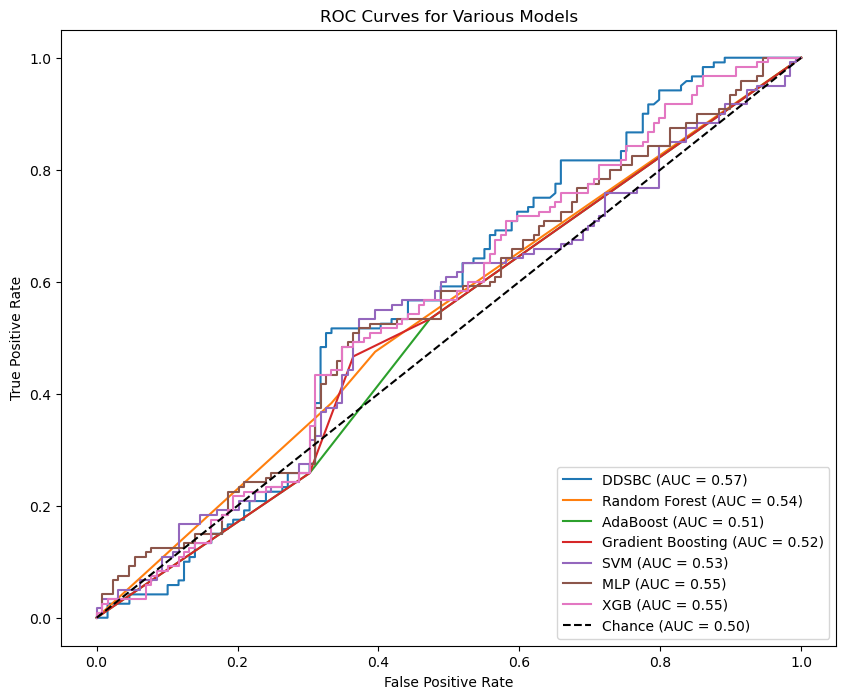

Accuracy:
	DDSBC: 0.58
	Random Forest: 0.53
	AdaBoost: 0.49
	Gradient Boosting: 0.55
	SVM: 0.51
	MLP: 0.56
	XGB: 0.56
F1-Score:
	DDSBC: 0.52
	Random Forest: 0.44
	AdaBoost: 0.33
	Gradient Boosting: 0.50
	SVM: 0.39
	MLP: 0.50
	XGB: 0.49
Recall:
	DDSBC: 0.47
	Random Forest: 0.38
	AdaBoost: 0.26
	Gradient Boosting: 0.47
	SVM: 0.33
	MLP: 0.46
	XGB: 0.44
Precision:
	DDSBC: 0.58
	Random Forest: 0.52
	AdaBoost: 0.44
	Gradient Boosting: 0.54
	SVM: 0.49
	MLP: 0.56
	XGB: 0.55
ROC AUC:
	DDSBC: 0.57
	Random Forest: 0.54
	AdaBoost: 0.51
	Gradient Boosting: 0.52
	SVM: 0.53
	MLP: 0.55
	XGB: 0.55


In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')
# Assuming 'datasetb' is already loaded as before
# Load the new dataset (254.csv)
new_dataset_path = '/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/254.csv'  # Change this to the actual path of 254.csv
new_dataseta = pd.read_csv(new_dataset_path)

# Ensure the 'cell' column is of the same data type
new_dataseta['cell'] = new_dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Merge the new dataset with 'datasetb' on 'cell'
combined_new_dataset = pd.merge(new_dataseta, datasetb, on='cell', how='inner')

# Apply the same preprocessing steps as you did for your training data
# Including SMILES encoding
combined_new_dataset['drug1_features'] = combined_new_dataset['drug1'].apply(enhanced_encode_smiles)
combined_new_dataset['drug2_features'] = combined_new_dataset['drug2'].apply(enhanced_encode_smiles)

# Assuming the new dataset also includes gene expression data that needs processing
new_gene_expression_data = combined_new_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust column names as necessary
new_gene_expression_scaled = scaler.transform(new_gene_expression_data)  # Use the same scaler as before
new_gene_expression_pca = pca.transform(new_gene_expression_scaled)  # Use the same PCA as before

# Combine PCA components with molecular features for the new dataset
features_combined_new = pd.DataFrame(np.concatenate((combined_new_dataset['drug1_features'].tolist(), combined_new_dataset['drug2_features'].tolist()), axis=1))
X_new = np.concatenate([new_gene_expression_pca, features_combined_new.values], axis=1)

# Ensure you have the true labels for the new dataset for evaluation
y_new_true = combined_new_dataset['label'].values  # Adjust if the label column name is different
# Assuming you have already preprocessed your new dataset and it's ready for prediction in `X_new`
# Also assuming `y_new_true` holds the true labels for the new dataset
# Assuming the setup and preprocessing steps remain the same and are executed before this code

# Initialize dictionaries to hold the scores for each metric for each model
scores = {
    "Accuracy": {},
    "F1-Score": {},
    "Recall": {},
    "Precision": {},
    "ROC AUC": {}
}

plt.figure(figsize=(10, 8))  # Prepare figure for ROC curves

# Loop through classifiers to predict, evaluate, and plot ROC
for name, clf in classifiers.items():
    y_new_pred = clf.predict(X_new)
    y_new_proba = clf.predict_proba(X_new)[:, 1]  # Get probabilities for the positive class
    
    # Calculate metrics
    scores["Accuracy"][name] = accuracy_score(y_new_true, y_new_pred)
    scores["F1-Score"][name] = f1_score(y_new_true, y_new_pred)
    scores["Recall"][name] = recall_score(y_new_true, y_new_pred)
    scores["Precision"][name] = precision_score(y_new_true, y_new_pred)
    scores["ROC AUC"][name] = roc_auc_score(y_new_true, y_new_proba)
    
    # Calculate ROC curve and plot
    fpr, tpr, _ = roc_curve(y_new_true, y_new_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {scores["ROC AUC"][name]:.2f})')

# Finalizing the ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()

# Print out the scores for each model
for metric, values in scores.items():
    print(f"{metric}:")
    for model_name, score in values.items():
        print(f"\t{model_name}: {score:.2f}")


PLOT ON INDEPENDETN DATASET

/var/folders/nh/jf0xzn491p92xfq2357y9fx40000gn/T/ipykernel_1380/2640220853.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = get_cmap('viridis')


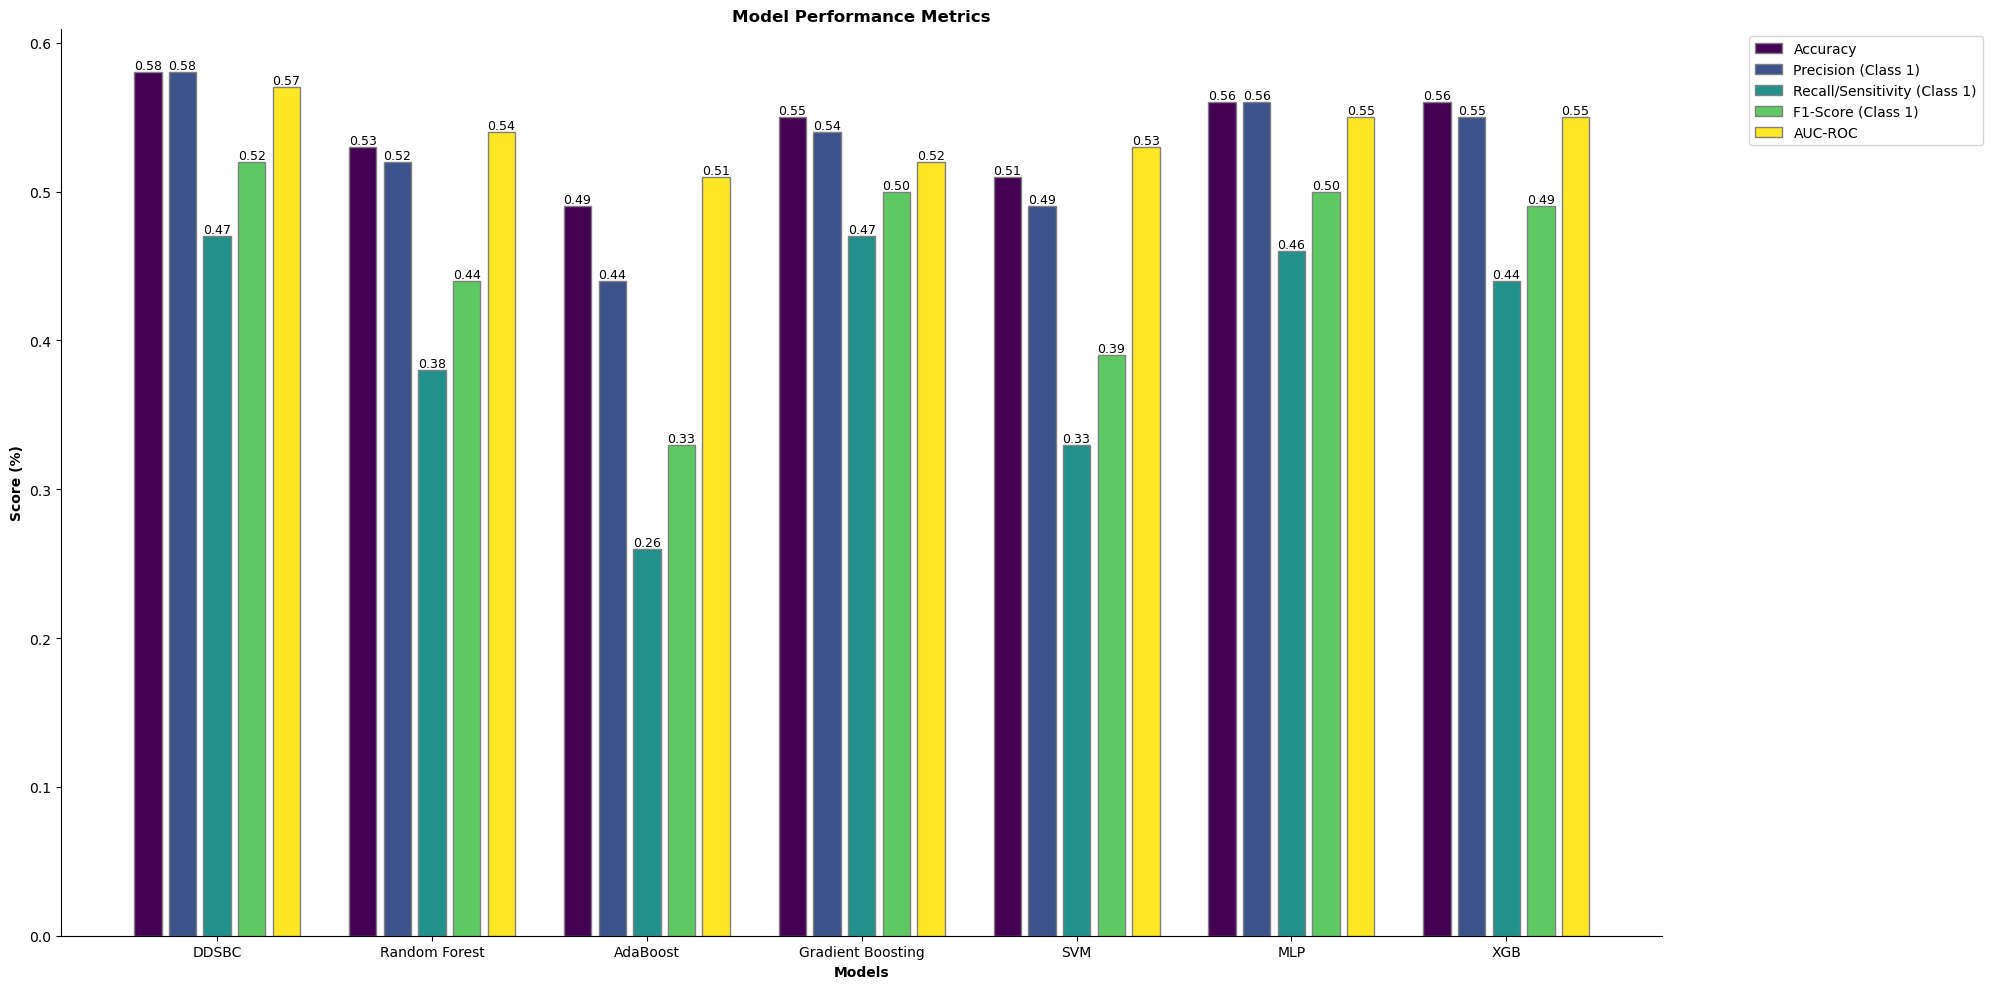

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# Model names
models = ['DDSBC', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM', 'MLP', 'XGB']

# Metrics - Replace these with your data
accuracy = [0.58, 0.53, 0.49, 0.55, 0.51, 0.56, 0.56]
precision = [0.58, 0.52, 0.44, 0.54, 0.49, 0.56, 0.55]  # Replace with your data
recall = [0.47, 0.38, 0.26, 0.47, 0.33, 0.46, 0.44]  # Replace with your data
f1_score = [0.52, 0.44, 0.33, 0.50, 0.39, 0.50, 0.49]
auc_roc = [0.57, 0.54, 0.51, 0.52, 0.53, 0.55, 0.55]  # Replace with your data

# Viridis color palette
viridis = get_cmap('viridis')
colors = viridis(np.linspace(0, 1, 5))  # Using the first 5 colors from the viridis colormap

# Adjusting the bar width and spacing
barWidth = 0.15
spaceBetweenBars = 0.04  # Space between individual bars within a group
spaceBetweenGroups = 0.1  # Increased spacing between groups for clear differentiation

# Calculate the positions of the bars
totalWidth = barWidth * 5 + spaceBetweenBars * 4  # Total width of a group of bars
groupStartPositions = np.linspace(0, len(models) * (totalWidth + spaceBetweenGroups), len(models))

r1 = groupStartPositions
r2 = [x + barWidth + spaceBetweenBars for x in r1]
r3 = [x + 2*(barWidth + spaceBetweenBars) for x in r1]
r4 = [x + 3*(barWidth + spaceBetweenBars) for x in r1]
r5 = [x + 4*(barWidth + spaceBetweenBars) for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))  # Adjusted figure size for better spacing

# Plotting the bars and adding the numbers
for i in range(len(models)):
    ax.bar(r1[i], accuracy[i], color=colors[0], width=barWidth, edgecolor='grey')
    ax.text(r1[i], accuracy[i], f'{accuracy[i]:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.bar(r2[i], precision[i], color=colors[1], width=barWidth, edgecolor='grey')
    ax.text(r2[i], precision[i], f'{precision[i]:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.bar(r3[i], recall[i], color=colors[2], width=barWidth, edgecolor='grey')
    ax.text(r3[i], recall[i], f'{recall[i]:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.bar(r4[i], f1_score[i], color=colors[3], width=barWidth, edgecolor='grey')
    ax.text(r4[i], f1_score[i], f'{f1_score[i]:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.bar(r5[i], auc_roc[i], color=colors[4], width=barWidth, edgecolor='grey')
    ax.text(r5[i], auc_roc[i], f'{auc_roc[i]:.2f}', ha='center', va='bottom', fontsize=9)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.xticks(groupStartPositions + 2*(barWidth + spaceBetweenBars), models, rotation=00)
plt.title('Model Performance Metrics', fontweight='bold')

# Adjust legend position
ax.legend(['Accuracy', 'Precision (Class 1)', 'Recall/Sensitivity (Class 1)', 'F1-Score (Class 1)', 'AUC-ROC'], loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()

# Show the plot
plt.savefig("model_performance_viridis.png", dpi=600)  # Saving the plot
plt.show()
